In [ ]:
###Forecasting with a stateful RNN

In [1]:
###Setup

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

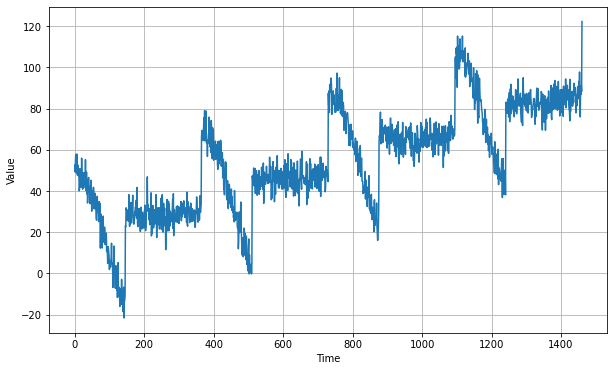

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
###Stateful RNN Forecasting

In [5]:
#we want consecutive batches to be sequential
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis = -1)
    ds = tf.data.Dataset.from_tensor_slices(series) # we want each batch to continue where the previous batch left off; we want each batch to continue where the previous batch left off
    ds = ds.window(window_size + 1, shift = window_size, drop_remainder = True) #this time shift = window_size; we don't use shuffle method because the batches need to be ordered
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [6]:
for X_batch, y_batch in sequential_window_dataset(tf.range(10), 3):
    print(X_batch.numpy(), y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


In [7]:
#we need to reset the state of the model at the beginning of every epoch, and for this, our own reset states callback is created

class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]), #input shape isn't specified, the batch input shape is specified, and that includes the batch dimension
  #two changes were made than the previous codes
  #the first change - the first dimension: it's going to be systematically equal to one as we created our sequential window function, we use batches containing a single window at a time
  #the second change - in the model, the fact that stateful equals are specified true in every recurrent layer,   
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(), #we compile the model as usual
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 6s 24ms/step - loss: 119.4312 - mae: 119.9312
Epoch 2/100
33/33 [==============================] - 0s 11ms/step - loss: 90.0518 - mae: 90.5518
Epoch 3/100
33/33 [==============================] - 0s 11ms/step - loss: 56.3640 - mae: 56.8630
Epoch 4/100
33/33 [==============================] - 0s 11ms/step - loss: 35.0965 - mae: 35.5923
Epoch 5/100
33/33 [==============================] - 0s 12ms/step - loss: 30.4513 - mae: 30.9471
Epoch 6/100
33/33 [==============================] - 0s 11ms/step - loss: 29.5937 - mae: 30.0834
Epoch 7/100
33/33 [==============================] - 0s 11ms/step - loss: 28.6775 - mae: 29.1709
Epoch 8/100
33/33 [==============================] - 0s 11ms/step - loss: 27.6872 - mae: 28.1803
Epoch 9/100
33/33 [==============================] - 0s 11ms/step - loss: 26.8164 - mae: 27.3123
Epoch 10/100
33/33 [==============================] - 0s 11ms/step - loss: 25.9618 - mae: 26.4572
Epoch 11/100
33/33 [=======

33/33 [==============================] - 0s 11ms/step - loss: 18.1510 - mae: 18.6472
Epoch 85/100
33/33 [==============================] - 0s 11ms/step - loss: 29.4554 - mae: 29.9523
Epoch 86/100
33/33 [==============================] - 0s 11ms/step - loss: 34.8600 - mae: 35.3570
Epoch 87/100
33/33 [==============================] - 0s 10ms/step - loss: 28.3893 - mae: 28.8861
Epoch 88/100
33/33 [==============================] - 0s 10ms/step - loss: 24.8611 - mae: 25.3599
Epoch 89/100
33/33 [==============================] - 0s 11ms/step - loss: 21.4902 - mae: 21.9854
Epoch 90/100
33/33 [==============================] - 0s 11ms/step - loss: 47.7410 - mae: 48.2401
Epoch 91/100
33/33 [==============================] - 0s 10ms/step - loss: 23.8199 - mae: 24.3164
Epoch 92/100
33/33 [==============================] - 0s 11ms/step - loss: 51.7019 - mae: 52.2010
Epoch 93/100
33/33 [==============================] - 0s 10ms/step - loss: 46.8600 - mae: 47.3599
Epoch 94/100
33/33 [=============

(1e-08, 0.0001, 0.0, 30.0)

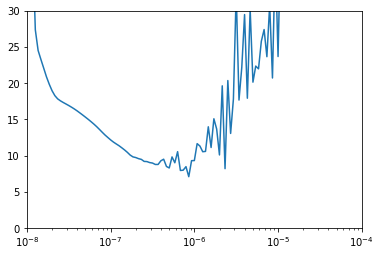

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [10]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 5s 73ms/step - loss: 92.9155 - mae: 93.4144 - val_loss: 25.0216 - val_mae: 25.5177
Epoch 2/500
33/33 [==============================] - 1s 16ms/step - loss: 29.4368 - mae: 29.9290 - val_loss: 10.9143 - val_mae: 11.4075
Epoch 3/500
33/33 [==============================] - 1s 15ms/step - loss: 25.5872 - mae: 26.0791 - val_loss: 12.0569 - val_mae: 12.5479
Epoch 4/500
33/33 [==============================] - 1s 16ms/step - loss: 23.9572 - mae: 24.4492 - val_loss: 10.4489 - val_mae: 10.9391
Epoch 5/500
33/33 [==============================] - 1s 15ms/step - loss: 23.0645 - mae: 23.5578 - val_loss: 9.9581 - val_mae: 10.4499
Epoch 6/500
33/33 [==============================] - 1s 15ms/step - loss: 22.0755 - mae: 22.5678 - val_loss: 9.1539 - val_mae: 9.6415
Epoch 7/500
33/33 [==============================] - 1s 16ms/step - loss: 21.2401 - mae: 21.7314 - val_loss: 8.3393 - val_mae: 8.8249
Epoch 8/500
33/33 [==============================] - 

Epoch 62/500
33/33 [==============================] - 0s 15ms/step - loss: 10.1982 - mae: 10.6775 - val_loss: 7.2324 - val_mae: 7.7192
Epoch 63/500
33/33 [==============================] - 0s 15ms/step - loss: 10.1329 - mae: 10.6120 - val_loss: 7.2252 - val_mae: 7.7119
Epoch 64/500
33/33 [==============================] - 1s 16ms/step - loss: 10.0694 - mae: 10.5482 - val_loss: 7.2330 - val_mae: 7.7197
Epoch 65/500
33/33 [==============================] - 0s 15ms/step - loss: 10.0091 - mae: 10.4884 - val_loss: 7.2639 - val_mae: 7.7507
Epoch 66/500
33/33 [==============================] - 1s 15ms/step - loss: 9.9512 - mae: 10.4314 - val_loss: 7.3072 - val_mae: 7.7941
Epoch 67/500
33/33 [==============================] - 0s 15ms/step - loss: 9.8932 - mae: 10.3741 - val_loss: 7.3386 - val_mae: 7.8257
Epoch 68/500
33/33 [==============================] - ETA: 0s - loss: 10.2325 - mae: 10.714 - 1s 16ms/step - loss: 9.8319 - mae: 10.3134 - val_loss: 7.3363 - val_mae: 7.8234
Epoch 69/500
33/33

In [11]:
#load the last model that was saved, which was the best model on the validation set, and then we can actually make predictions with our model
#so, we first reset the states to make sure that it doesn't have remaining state from training, and we can actually call the predict method giving it the full time series
#we give it a reshaped time series, the original time series as one-dimensional, but the model expects a 3 dimensional array
#The first dimension should be one or last dimension should be one, and these are time-steps
#Once we have the predictions on the full time series we, extract the only part that we're interested in, which is the validation period

model = keras.models.load_model("my_checkpoint.h5")

In [12]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

In [13]:
#so, that's our RNN forecasts

rnn_forecast.shape

(461,)

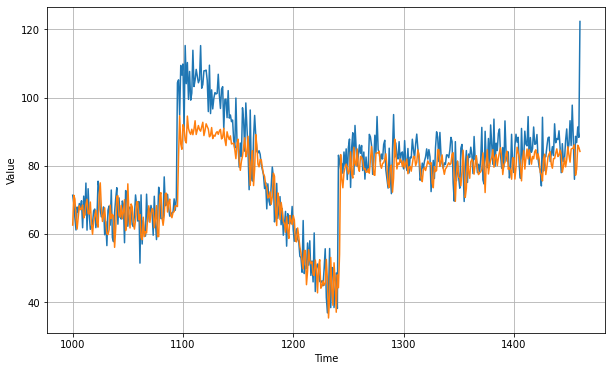

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [15]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

6.2778454